## Creation of artificial data

Data are created artificially with a mixed Gaussian distribution of two clusters, with specific means and standard deviations

In [18]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

"""
Creates the data to be used for training, using a GMM distribution
@param size_sample, the number of sample per class
@param mean1, means for sample from the class 1
@param mean2, means for sample from the class 2
@param stds1, standard deviation for sample, class 1
@param stds2, standard deviation for sample, class 2
"""
def createData(size_sample = 2, mean1 = [15, 16], mean2 = [5, 5], stds1 = [5, 6], stds2 = [2, 1]):
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(size_sample, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    covarianceMatrix[0, 1] = -4.0
    covarianceMatrix[1, 0] = -4.0
    sampleClass1 = createDataOneClass(means, covarianceMatrix, size_sample)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 1] = 0.0
    covarianceMatrix[1, 0] = 0.0
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    sampleClass2 = createDataOneClass(means, covarianceMatrix, size_sample)
    # Concatenates the ones for the bias
   
    sampleAll = torch.cat((sampleClass1, sampleClass2), 0)
    plt.scatter(sampleClass1[:, 0], sampleClass1[:, 1])
    plt.scatter(sampleClass2[:, 0], sampleClass2[:, 1], color='red')
    plt.show()
    targets_all = torch.cat((torch.zeros(size_sample, 1), torch.ones(size_sample, 1)), 0)
    #print(targets_all)
    return (sampleAll, targets_all)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, size_sample):
    # Inits the bi gaussian data generator
    multiGauss_generator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the sample
    sample = multiGauss_generator.sample(torch.Size([size_sample]))
    
    return sample

## Train GDA model
Calculate the covariance matrix and the means for each dataset

In [27]:
def calculate_covariance_and_mean(sample_data, labels_data, label_stats):
  """
  Assume that the sample is from the same class
  sample_class: matrix with all the data
  return: mean and covariance of the data
  Estimates the mean and covariance from the data, equivalent to model training
  """
  num_dimensions = sample_data.shape[1]
  num_observations = sample_data.shape[0]
  #extract the observations of the class to calculate its covariance and mean
  observations_to_extract = labels_data == label_stats
  #print("observations_to_extract shape ", observations_to_extract.shape)
  #indexing_matrix = observations_to_extract.repeat(1, num_dimensions)
  indices = (labels_data == label_stats).squeeze()
  #print("indices ", indices.shape)
  sample_data_class = sample_data[indices]
  #calculate covariance matrix
  covariance_matrix = torch.cov(sample_data_class.transpose(0, 1))
  print(covariance_matrix)
  mean_class = sample_data_class.mean(dim = 0).unsqueeze(0).transpose(0, 1)
  return (mean_class, covariance_matrix)

def evaluate_gaussian_2d(mu_array, Sigma, x_array):
    """
    Evaluate the gaussian 2d value in a specific x
    Assumes both are pytorch 2d arrays
    """
    num_dimensions = mu_array.shape[0]    
    determinant_Sigma = torch.det(Sigma)
    #normalization factor
    norm_factor =  1 / (torch.sqrt((2 * torch.pi)** torch.tensor(num_dimensions)) * torch.sqrt(determinant_Sigma))
    #cuadratic form exponent
    cuadratic_form = (x_array - mu_array).transpose(0, 1).mm(Sigma.inverse()).mm(x_array - mu_array)    
    #final value
    gauss_result = norm_factor * torch.exp(-0.5*cuadratic_form)
    return gauss_result  

def evaluate_model(mu_1, Sigma_1, mu_2, Sigma_2, dataset, targets):
  """
  Evaluates a given bi-gaussian model for binary classification using the given parameters
  """
  num_observations = dataset.shape[0]
  num_incorrect = 0
  for i in range(0, num_observations):
    #calculate the likelihood for each observation...
    x_array = dataset[i, :].unsqueeze(0).transpose(0, 1)
    likelihood_gauss_1 = evaluate_gaussian_2d(mu_1, Sigma_1, x_array)
    likelihood_gauss_2 = evaluate_gaussian_2d(mu_2, Sigma_2, x_array)
    #Decide the estimated target according to it
    estimated_target = 0
    if(likelihood_gauss_2 > likelihood_gauss_1):
      estimated_target = 1
    if(estimated_target != targets[i]):
      num_incorrect += 1

  return num_incorrect / num_observations



In [93]:
a = torch.tensor([[1, 5], [2.0, 6], [3, 9]])
indices = a[:, 0] > 1
print(indices)
c = a[a[:, 0] > 1]
print(c)

tensor([False,  True,  True])
tensor([[2., 6.],
        [3., 9.]])


## Test 
Test the method classifying the same training data

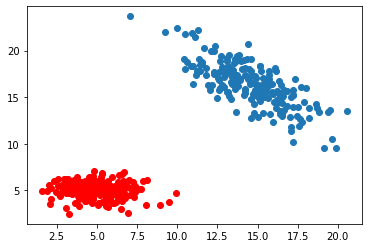

sample_all shape!  torch.Size([400, 2])
tensor([[ 4.9735, -4.0655],
        [-4.0655,  5.7442]])
tensor([[ 2.2249, -0.1061],
        [-0.1061,  0.7747]])
mean_class1 
 tensor([[14.6034],
        [16.3335]])
Covariance matrix 1 
  tensor([[ 4.9735, -4.0655],
        [-4.0655,  5.7442]])
mean_class2 
 tensor([[5.0425],
        [4.9826]])
Covariance matrix  2 
 torch.Size([2, 2])
Error rate  0.0


In [28]:
"""
Main function
"""
def main():
    (sample_all, targets_all) = createData(size_sample = 200)
    print("sample_all shape! ", sample_all.shape)
    (mean_class1, covariance_matrix1) = calculate_covariance_and_mean(sample_all, targets_all, label_stats = 0)
    (mean_class2, covariance_matrix2) = calculate_covariance_and_mean(sample_all, targets_all, label_stats = 1)    
    print("mean_class1 \n", mean_class1)
    print("Covariance matrix 1 \n ", covariance_matrix1)
    print("mean_class2 \n", mean_class2)
    print("Covariance matrix  2 \n", covariance_matrix2.shape)
    error_rate = evaluate_model(mean_class1, covariance_matrix1, mean_class2, covariance_matrix2, sample_all, targets_all)
    print("Error rate ", error_rate)
main()